In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as colors
import contextily as cx
from os.path import join
import pickle
from shapely.geometry import Point, box
from shapely.ops import transform
import pyproj
from correlate import zero_lag_correlate
from filtering import freq_filt
from tqdm import tqdm

In [5]:
data_dir = '/bsuscratch/zacharykeskinen/data/infrasound/array_data'
with open(join(data_dir, 'merged/all_days'), 'rb') as f:
    days = pickle.load(f)
sps = 200

In [6]:
banner_coords = (44.3, -115.233)
url = f'https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime=2021-12-01&endtime=2022-06-15&latitude={banner_coords[0]}&longitude={banner_coords[1]}&maxradiuskm=30'
df = pd.read_csv(url)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs = 'EPSG:4326')
res = gdf.loc[:, ['time', 'geometry', 'depth', 'mag', 'id']]

In [7]:
# Calculate Distance to Snotel from Source
wgs84 = pyproj.CRS('EPSG:4326')
itm = pyproj.CRS('EPSG:8826') # Idaho Tranvserse Mercator - https://epsg.io/8826
project = pyproj.Transformer.from_crs(wgs84, itm, always_xy=True).transform
wgs_snotel = Point(*banner_coords[::-1])
itm_snotel = transform(project, wgs_snotel)
res_geo = res.to_crs('EPSG:8826')
res.loc[:, 'distance_km'] = res_geo.distance(itm_snotel)/1000 # convert m to km
# Calculate Azimuth
geodesic = pyproj.Geod(ellps='WGS84')
for i,r in res.iterrows():
    fwd_azimuth,_,_ = geodesic.inv(wgs_snotel.x, wgs_snotel.y, r.geometry.x, r.geometry.y)
    res.loc[i, 'azimuth'] = fwd_azimuth

In [8]:
for i, r in tqdm(res.iterrows(), total = len(res)):
        dt = pd.to_datetime(r.time).strftime('%Y-%m-%d')
        if dt in days.keys():
            day = days[dt]
            if 0.33 in day.keys():
                s = pd.to_datetime(r.time)
                ps = s - pd.Timedelta('20 seconds') 
                e = s + pd.Timedelta('20 seconds')
                d = {}
                d['lower'] = pd.read_parquet(day[0.33])
                d['upper'] = pd.read_parquet(day[1])
                try:
                    pre = freq_filt(d['lower'].loc[ps:s, :].values.ravel(), fc = 1, kind = 'highpass', sps = sps)
                    pre_mean = np.nanmean(pre**2)
                    for k in d.keys():
                        d[k] = d[k].loc[s:e, :].values.ravel()
                        d[k] = freq_filt(d[k], fc = 1, kind = 'highpass', sps = sps)
                    corr = zero_lag_correlate(d['lower'], d['upper'], 2)[:-10]
                    max_corr = np.nanmax(corr)
                    res.loc[i, 'max_corr'] = max_corr
                    res.loc[i, 'mean_corr'] = np.nanmean(corr)
                    res.loc[i, 'corr_95'] = np.nanquantile(corr, 0.95)
                    eq_mean = np.nanmean(d['lower']**2)
                    mean_ratio = np.abs(eq_mean/pre_mean)
                    res.loc[i, 'mean_ratio'] = mean_ratio
                    if np.nanmax(corr) > 0.5 and mean_ratio > 1.5 and np.nanmean(corr) < 0.9:
                        res.loc[i, 'selected'] = 1
                    else:
                        res.loc[i, 'selected'] = 0
                except ValueError:
                    pass
# res.selected[np.isnan(res.selected), 'selected'] = 0

  0%|          | 0/469 [00:00<?, ?it/s]/bsuhome/zacharykeskinen/infrasound/src/functions/correlate.py:13: RuntimeWarning: invalid value encountered in double_scalars
  return np.einsum('i,i->',A_mA,B_mB)/np.sqrt(ssA*ssB)
  0%|          | 1/469 [00:03<25:33,  3.28s/it]/bsuhome/zacharykeskinen/infrasound/src/functions/correlate.py:13: RuntimeWarning: invalid value encountered in double_scalars
  return np.einsum('i,i->',A_mA,B_mB)/np.sqrt(ssA*ssB)
 15%|█▍        | 69/469 [03:40<21:16,  3.19s/it]

: 

: 

In [ ]:
j = 0
n = 12
plot_n = 10
for i, r in res.iterrows():
    if r.selected == 1:
        j +=1
    if j < (n+1)*plot_n and j > n*plot_n and r.selected == 1:
        f, ax = plt.subplots(1,2, figsize = (16,4))
        s = pd.to_datetime(r.time)
        e = s + pd.Timedelta('20 seconds')
        dt = pd.to_datetime(r.time).strftime('%Y-%m-%d')
        day = days[dt]
        d['lower'] = pd.read_parquet(day[0.33])
        d['upper'] = pd.read_parquet(day[1])
        for l, k in enumerate(d.keys()):
            d[k] = d[k].loc[s:e, :].values.ravel()
            d[k] = freq_filt(d[k], fc = 1, kind = 'highpass', sps = sps)
            ax[l].plot(d[k])
        plt.show()
    if j > (n+1)*plot_n:
        break

import osmnx as ox

G = ox.graph_from_point(banner_coords, dist=20000, retain_all=True, simplify = True, network_type='all')

u = []
v = []
key = []
data = []
for uu, vv, kkey, ddata in G.edges(keys=True, data=True):
    u.append(uu)
    v.append(vv)
    key.append(kkey)
    data.append(ddata)
# Lists to store colors and widths 
roadColors = []
roadWidths = []

for item in data:
    if "primary" in item["highway"]:
        linewidth = 1.5
        color = "#666699"
    else:
        color = "#000000"
        linewidth = 0
            
    roadColors.append(color)
    roadWidths.append(linewidth)

import py3dep

geom = gdf.geometry.total_bounds
geom = tuple(geom)
hs = py3dep.get_map("Hillshade Gray", geom, resolution=30, geo_crs="epsg:4326", crs="epsg:4326")

In [ ]:
gdf = gpd.read_file('~/scratch/data/infrasound/dem/tl_2021_us_county.shp')

NameError: name 'gpd' is not defined

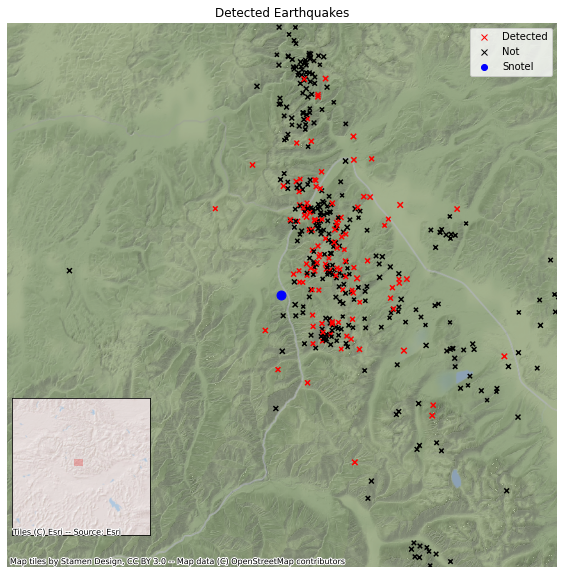

In [250]:
f, ax = plt.subplots(figsize=(16, 10))
ax2 = inset_axes(ax, "25%", "35%", loc="lower left")
ax2.set_ylim([39, 49])
ax2.set_xlim([-120, -110])
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
bbox = box(*geom)
# ax2.plot(*bbox.exterior.xy)
gpd.GeoSeries(bbox).plot(ax = ax2, linewidth = 1, facecolor = 'red', edgecolor = 'red')
cx.add_basemap(crs = gdf.crs, alpha = .8, zorder = 2, ax = ax2, source=cx.providers.Esri.WorldShadedRelief)

selected_dic = {1:'red',0:'black'}
cs = [selected_dic[sel] for sel in res.selected]
sc = ax.scatter(x = res.geometry.x, y = res.geometry.y, s=res.mag*10, color = cs, marker = 'x', zorder = 3)
# Basemap and snotel
ax.scatter(x = banner_coords[1], y = banner_coords[0], s = 80, color = 'blue', marker = 'o', zorder = 3)
cx.add_basemap(ax, crs = gdf.crs, source = cx.providers.Stamen.Terrain, alpha = .8, zorder = 2)
hs.plot(ax = ax, zorder = 1, cmap = 'Greys', alpha = 1, add_colorbar=False)
ax.set_title('Detected Earthquakes')
# The following two lines generate custom fake lines that will be used as legend entries:
markers = [plt.Line2D([0,0],[0,0],color=color, marker='x', linestyle='') for color in selected_dic.values()]
markers.append(plt.Line2D([0,0],[0,0],color='blue', marker='o', linestyle=''))
ax.legend(markers, ['Detected', 'Not', 'Snotel'], numpoints=1)
# Plot roads
ox.plot_graph(G, ax = ax, node_size=0,
                        dpi = 120,
                        save = False, edge_color=roadColors,
                        edge_linewidth=roadWidths, edge_alpha=0.6)
plt.show()